# Imports

In [82]:
import math
import pandas as pd
import pennylane as qml

from matplotlib import pyplot as plt
from pennylane import numpy as np
from pennylane.templates import AmplitudeEmbedding, AngleEmbedding
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Model Params

In [63]:
np.random.seed(42)
initial_params = np.random.random([7])

CLASS_TO_IGNORE = 0  # third class, 0, 1, 2
INITIALIZATION_METHOD = 'Angle'
EPOCHS = 10
TEST_SIZE = 0.2
STEP_SIZE = 0.3
STEPS = int((1-TEST_SIZE)*100*EPOCHS)

# Import dataset

In [64]:
X, y = load_iris(return_X_y=True)

if CLASS_TO_IGNORE == 0:
    # Drop first class
    X = X[50:]
    y = y[50:]
    y_scaled = np.where(y == 1, 0, y)
    y_scaled = np.where(y_scaled == 2, 1, y_scaled)

elif CLASS_TO_IGNORE == 1:
    # Drop second class
    X = np.delete(X, range(50, 100))
    y = np.delete(y, range(50, 100))
    y_scaled = np.where(y == 0, 0, y)
    y_scaled = np.where(y_scaled == 2, 1, y_scaled)

else:
    # Drop third class
    X = X[:100]
    y = y[:100]

In [65]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=TEST_SIZE, shuffle=True)

# Circuit creation

In [66]:
device = qml.device("default.qubit", wires=4)

In [67]:
@qml.qnode(device)
def circuit(features, params):
    # Load state
    if INITIALIZATION_METHOD == 'Amplitude':
        AmplitudeEmbedding(features=features, wires=range(4), normalize=True, pad_with=0.)
    else:
        AngleEmbedding(features=features, wires=range(4), rotation='Y')

    # First layer
    qml.RY(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RY(params[2], wires=2)
    qml.RY(params[3], wires=3)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[3, 2])

    # Second layer
    qml.RY(params[4], wires=1)
    qml.RY(params[5], wires=2)
    qml.CNOT(wires=[1, 2])

    # Third layer
    qml.RY(params[6], wires=2)

    # Measurement
    return qml.expval(qml.PauliZ(2))

## Circuit example

In [68]:
features = X_train[0]
print(f"Inital parameters: {initial_params}\n")
print(f"Example features: {features}\n")
print(f"Expectation value: {circuit(features, initial_params)}\n")
print(circuit.draw())

Inital parameters: [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452
 0.05808361]

Example features: [0.05761837 1.59476592 0.84485761 1.71304456]

Expectation value: 0.06793688976770845

 0: ──RY(0.0576)──RY(0.375)──╭C─────────────────────────────┤     
 1: ──RY(1.59)────RY(0.951)──╰X──RY(0.156)──╭C──────────────┤     
 2: ──RY(0.845)───RY(0.732)──╭X──RY(0.156)──╰X──RY(0.0581)──┤ ⟨Z⟩ 
 3: ──RY(1.71)────RY(0.599)──╰C─────────────────────────────┤     



# Training

In [69]:
params = initial_params
opt = qml.GradientDescentOptimizer(stepsize=STEP_SIZE)

for i in range(STEPS):
    features = X_train[i%len(X_train)]
    expected_value = y_train[i%len(X_train)]

    def cost(circuit_params):
        value = circuit(features, circuit_params)
        return ((expected_value - value) ** 2)/len(X_train)

    params = opt.step(cost, params)

In [70]:
print("Optimized rotation angles: {}".format(params))

Optimized rotation angles: [ 0.41639894  1.00069285  0.62770807  0.41965528  0.31215649  0.14570258
 -0.88418654]


# Testing

In [85]:
prediction_class = np.array([])
prediction_values = np.array([])
for example, example_class in zip(X_test, y_test):
    predicted_value = circuit(example, params)
    prediction_values = np.append(prediction_values, predicted_value)

    if predicted_value <= 0.5:
        prediction_class = np.append(prediction_class, 0)
    else:
        prediction_class = np.append(prediction_class, 1)

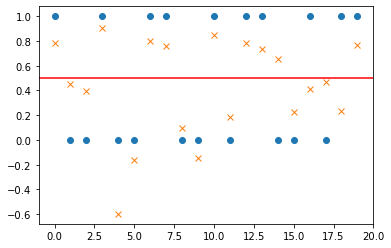

In [93]:
plt.xlim([-1, 20])
plt.plot(y_test, 'o')
plt.plot(prediction_values, 'x')
plt.axhline(y=0.5, color='r', linestyle='-')